In [1]:
using JLD2, DataFrames, CairoMakie
using FreqTables
using Jchemo, JchemoData

### Data importation

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/challenge2018.jld2")
@load db dat
pnames(dat)

X = dat.X
ntot = nro(X)
summ(X)

(res = 680×7 DataFrame
 Row │ variable  mean     std      min      max       n      nmissing 
     │ Symbol    Float64  Float64  Float64  Float64   Int64  Int64    
─────┼────────────────────────────────────────────────────────────────
   1 │ 1120        0.689    0.166    0.225  1.17799    4075         0
   2 │ 1122        0.689    0.166    0.226  1.17587    4075         0
   3 │ 1124        0.688    0.166    0.227  1.17326    4075         0
   4 │ 1126        0.687    0.165    0.228  1.16997    4075         0
   5 │ 1128        0.685    0.165    0.229  1.16602    4075         0
   6 │ 1130        0.683    0.164    0.23   1.16148    4075         0
   7 │ 1132        0.681    0.164    0.231  1.15625    4075         0
   8 │ 1134        0.679    0.164    0.232  1.15048    4075         0
  ⋮  │    ⋮         ⋮        ⋮        ⋮        ⋮        ⋮       ⋮
 674 │ 2466        0.18     0.099    0.031  0.456267   4075         0
 675 │ 2468        0.179    0.098    0.031  0.4537     4075         

In [3]:
Y = dat.Y
summ(Y)

(res = 4×7 DataFrame
 Row │ variable  mean    std     min          max          n      nmissing 
     │ Symbol    Union…  Union…  Any          Any          Int64  Int64    
─────┼─────────────────────────────────────────────────────────────────────
   1 │ typ                       ANF          TTS           4075         0
   2 │ label                     animal feed  wheat (ung)   4075         0
   3 │ conc      31.93   20.348  2.766        76.604        4075         0
   4 │ test      0.092   0.289   0            1             4075         0, ntot = 4075)

In [4]:
wl = names(X)
wl_num = parse.(Float64, wl)

typ = Y.typ
test = Y.test

z = string.(typ, "-", Y.label)
tab(z)

OrderedCollections.OrderedDict{String, Int64} with 10 entries:
  "ANF-animal feed"         => 391
  "CLZ-rapeseed(ung)"       => 420
  "CNG-corn gluten"         => 395
  "EHH-grass silage"        => 422
  "FFS-full fat soya"       => 432
  "FRG-wheat (ung)"         => 411
  "MPW-milk powder & whey"  => 410
  "PEE-maize wp"            => 407
  "SFG-sun flower seed(gr)" => 281
  "TTS-soya meal"           => 506

In [5]:
freqtable(z)

10-element Named Vector{Int64}
Dim1                    │ 
────────────────────────┼────
ANF-animal feed         │ 391
CLZ-rapeseed(ung)       │ 420
CNG-corn gluten         │ 395
EHH-grass silage        │ 422
FFS-full fat soya       │ 432
FRG-wheat (ung)         │ 411
MPW-milk powder & whey  │ 410
PEE-maize wp            │ 407
SFG-sun flower seed(gr) │ 281
TTS-soya meal           │ 506

In [6]:
freqtable(typ, test)

10×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
ANF         │ 351   40
CLZ         │ 378   42
CNG         │ 356   39
EHH         │ 380   42
FFS         │ 397   35
FRG         │ 371   40
MPW         │ 372   38
PEE         │ 367   40
SFG         │ 272    9
TTS         │ 457   49

### Preprocesssing

In [7]:
# Preprocesssing
f = 21 ; pol = 3 ; d = 2
Xp = savgol(snv(X); f = f, pol = pol, d = d)

@head Xp

... (4075, 680)
 


3×680 Matrix{Float64}:
 -0.00393533  -0.00441755  -0.00477681  …  0.000514478  0.000481081
 -0.00121436  -0.0013095   -0.00135921     0.000996321  0.000930884
 -0.00355712  -0.00399785  -0.00434838     0.00044084   0.000421751

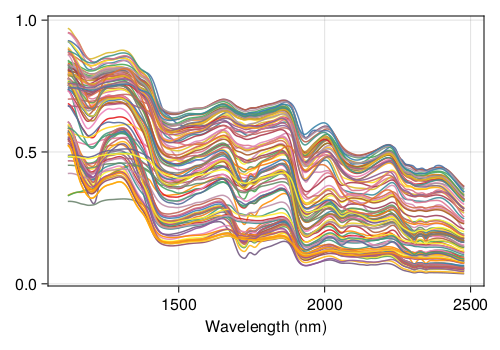

In [8]:
plotsp(X, wl_num; nsamp = 100,
    xlabel = "Wavelength (nm)").f

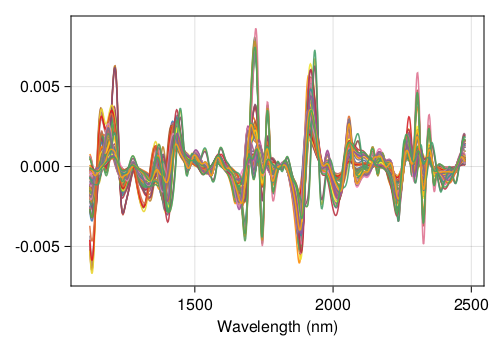

In [9]:
plotsp(Xp, wl_num; nsamp = 100,
    xlabel = "Wavelength (nm)").f

### PCA

Splitting: Tot = Train + Test

The PCA is fitted on Train, and Test will be
the supplementary observations.

Here the splitting is provided by the dataset
(= variable *typ*) but, alternatively, data Tot could be splitted
a posteriori (e.g. random sampling, systematic
sampling, etc.)

In [10]:
s = Bool.(test)
# or: s = test .== 1
Xtrain = rmrow(Xp, s)
Ytrain = rmrow(Y, s)
Xtest = Xp[s, :]
Ytest = Y[s, :]
ntrain = nro(Xtrain)
ntest = nro(Xtest)
(ntot = ntot, ntrain, ntest)

(ntot = 4075, ntrain = 3701, ntest = 374)

#### Model fitting (Train)

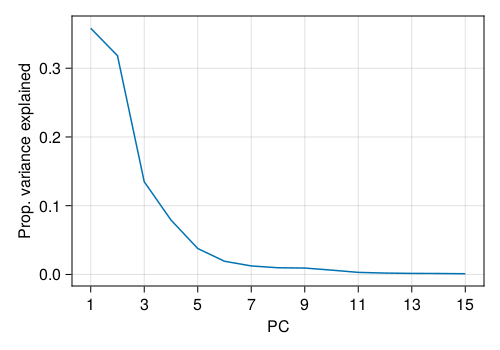

In [11]:
nlv = 15
fm = pcasvd(Xtrain, nlv = nlv) ;
pnames(fm)

res = summary(fm, Xtrain).explvarx

plotgrid(res.lv, res.pvar; step = 2,
    xlabel = "PC",
    ylabel = "Prop. variance explained").f

#### Projection of Test in the Train score-space

Below function *transform* has to be qualified
since both packages Jchemo and DataFrames export
a function *transform*.

This will be the same with common function names
such as *predict*, *coef*, etc.

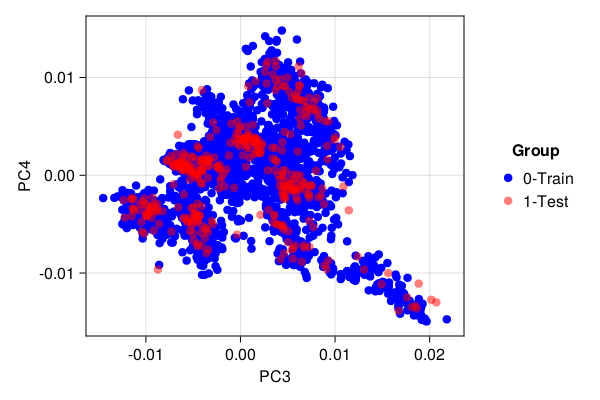

In [12]:
Ttrain = fm.T
Ttest = Jchemo.transform(fm, Xtest)

T = vcat(Ttrain, Ttest)
group = vcat(repeat(["0-Train";], ntrain),
repeat(["1-Test";], ntest))
colm = [:blue, (:red, .5)]
# Plot scores i, i + 1
i = 3
plotxy(T[:, i:(i + 1)], group; color = colm,
    xlabel = string("PC", i),
    ylabel = string("PC", i + 1)).f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*